In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

#from scipy.signal import lfilter
#from math import atan2, degrees, radians

import bee_simulator
import central_complex
import cx_basic
import cx_rate

import analysis
import plotter2

import modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Environment
nest_radius = 15   # Area in which the agent feels like home
feeder_radius = 20

In [31]:
# Set the cx model type and logger type here for easy access

cx = cx_rate.CXRatePontinHolonomic(noise=0.1)   # Latest CX model with pontine cells + holonomic movement
CXLogger = modules.trials2.CXLogger

# Example of foodward routes

In [46]:
# Generate a random walk
h_p1, v_p1, T_p1, log_p1, success = modules.move(goal_coord=None,
                                                 T_max=5000,
                                                 goal_radius=feeder_radius,
                                                 random_exploring=True,
                                                 arena=False,
                                                 stop_when_food=True,
                                                 logging=True,
                                                 return_success=True
                                                )


# Use the end-point as a goal for food-ward route
goal = np.cumsum(v_p1, axis=0)[-1]


# Perform the food-ward route
h_p2, v_p2, T_p2, log_p2, detection = modules.move(goal_coord=goal,
                                                   T_max=5000,
                                                   ltm=log_p1.memory[:,-1],
                                                   goal_radius=feeder_radius,
                                                   random_exploring=False,
                                                   arena=False,
                                                   stop_when_food=True,
                                                   logging=True,
                                                   return_success=False,
                                                   inhib_gain=1.05,
                                                   keep_searching=True # Keep searching until T_max is reached
                                                  )
if len(detection) > 0:
    print('yes')
else:
    print('no')

yes


In [49]:
# First time step at which goal is reached
detection[0]

1911

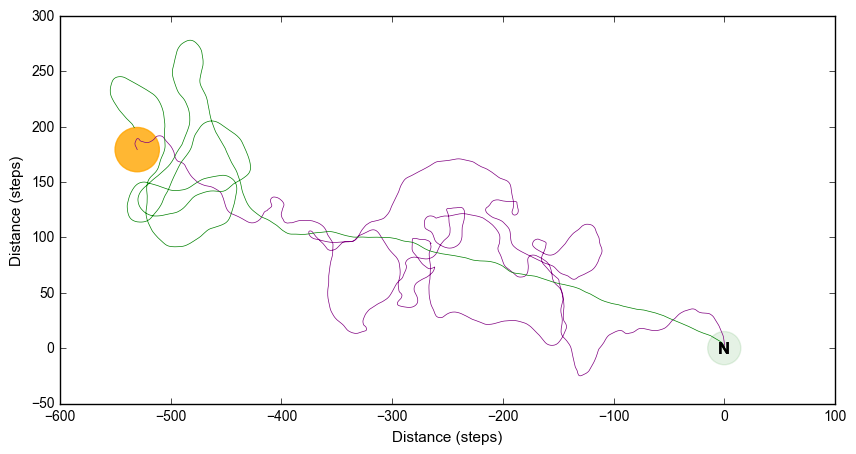

In [50]:
# Trace routes

fig, ax = plotter2.plot_route(h_p1,
                             v_p1,
                             T_outbound=T_p1,
                             T_inbound=0,
                             plot_speed=False,
                             plot_heading=False,
                             nest_label=True,
                             legend=False,
                             figsize=figsize,
                            )

plotter2.plot_route(h_p2,
                   v_p2,
                   ax=ax,
                   T_outbound=0,
                   T_inbound=detection[0], # We cut after first time step st which goal is reached
                   plot_speed=False,
                   plot_heading=False,
                   nest_label=True,
                   legend=False,
                   figsize=figsize,
                  )

ax.add_artist(plt.Circle(goal, feeder_radius, color='orange', alpha=.8))
ax.add_artist(plt.Circle((0,0), 15, color='g', alpha=.1))

### Plot the memory trace for just one time step (e.g. the last one)

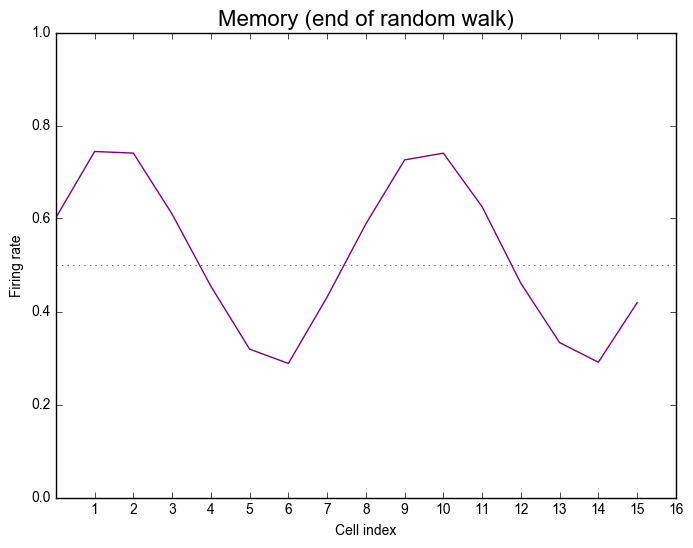

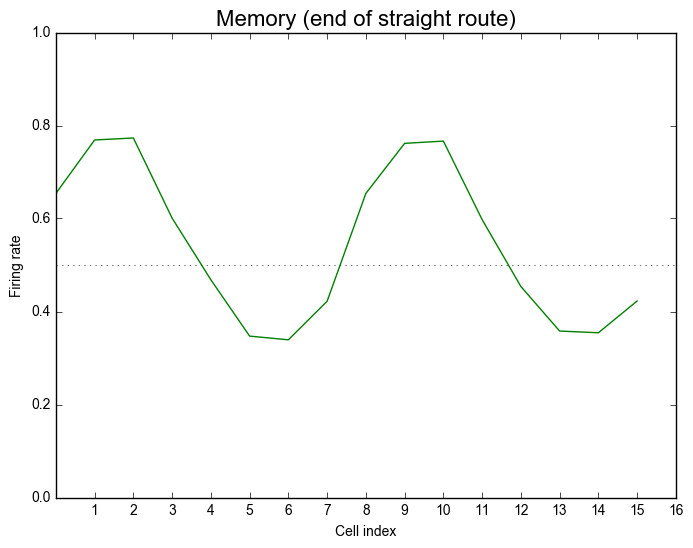

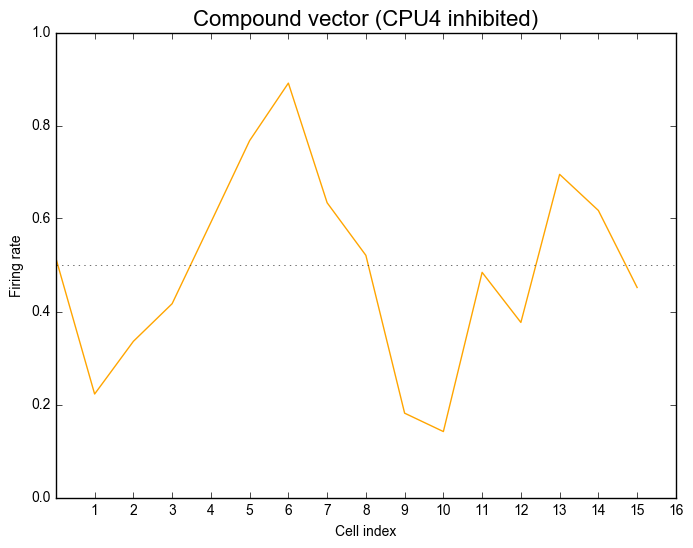

In [59]:
mem_rand = log_p1.memory[:,-1] # Memory at the last time step of the rand walk
mem_straight = log_p2.memory[:,-1] # Memory at the last time step of food-ward route
compound = log_p2.cpu4_inh[:,0] # Compound activity at first time step of food-ward route


# Plot
fig, ax = plt.subplots(figsize=(8,6))
base = 0.5*np.ones(16)

ax.plot(mem_rand, color='purple')

ax.set_ylim([0, 1])
ax.set_xlim([0, 16])
ax.set_xticks(range(1, 17))
ax.axhline(y=0.5, lw=0.5, c='#333333', linestyle='dotted')

ax.set_ylabel('Firing rate')
ax.set_xlabel('Cell index')
ax.set_title('Memory (end of random walk)', fontsize=16)


# Plot
fig, ax = plt.subplots(figsize=(8,6))
base = 0.5*np.ones(16)

ax.plot(mem_straight, color='green')

ax.set_ylim([0, 1])
ax.set_xlim([0, 16])
ax.set_xticks(range(1, 17))
ax.axhline(y=0.5, lw=0.5, c='#333333', linestyle='dotted')

ax.set_ylabel('Firing rate')
ax.set_xlabel('Cell index')
ax.set_title('Memory (end of straight route)', fontsize=16)


# Plot
fig, ax = plt.subplots(figsize=(8,6))
base = 0.5*np.ones(16)

ax.plot(compound, color='orange')

ax.set_ylim([0, 1])
ax.set_xlim([0, 16])
ax.set_xticks(range(1, 17))
ax.axhline(y=0.5, lw=0.5, c='#333333', linestyle='dotted')

ax.set_ylabel('Firing rate')
ax.set_xlabel('Cell index')
ax.set_title('Compound vector (CPU4 inhibited)', fontsize=16)

### Plot the activity for both routes

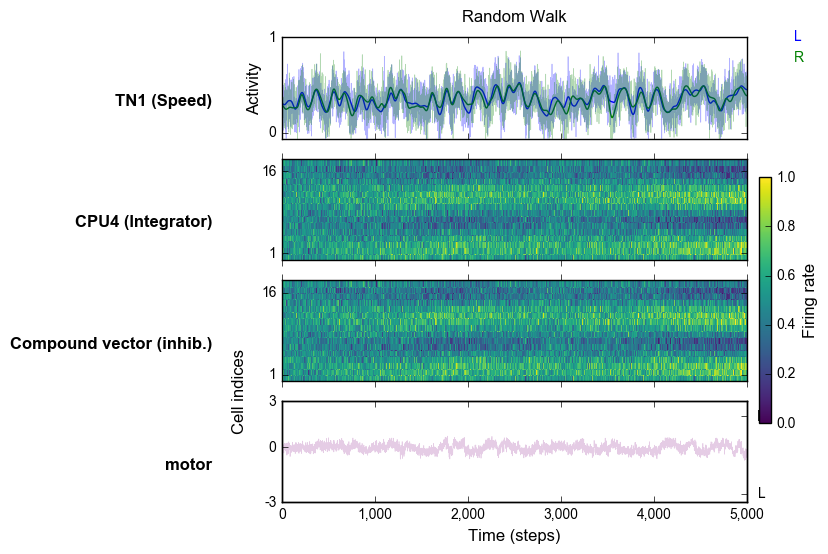

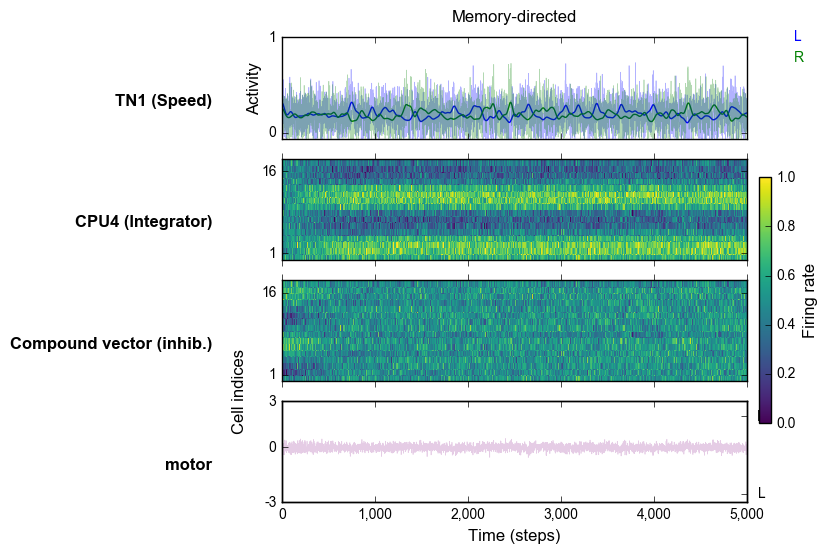

In [52]:
fig, ax = plotter2.plot_traces(
        log_p1, include=['TN1', 'CPU4', 'INH', 'motor'], single_move='Random Walk')

fig, ax = plotter2.plot_traces(
        log_p2, include=['TN1', 'CPU4', 'INH', 'motor'], single_move='Memory-directed')

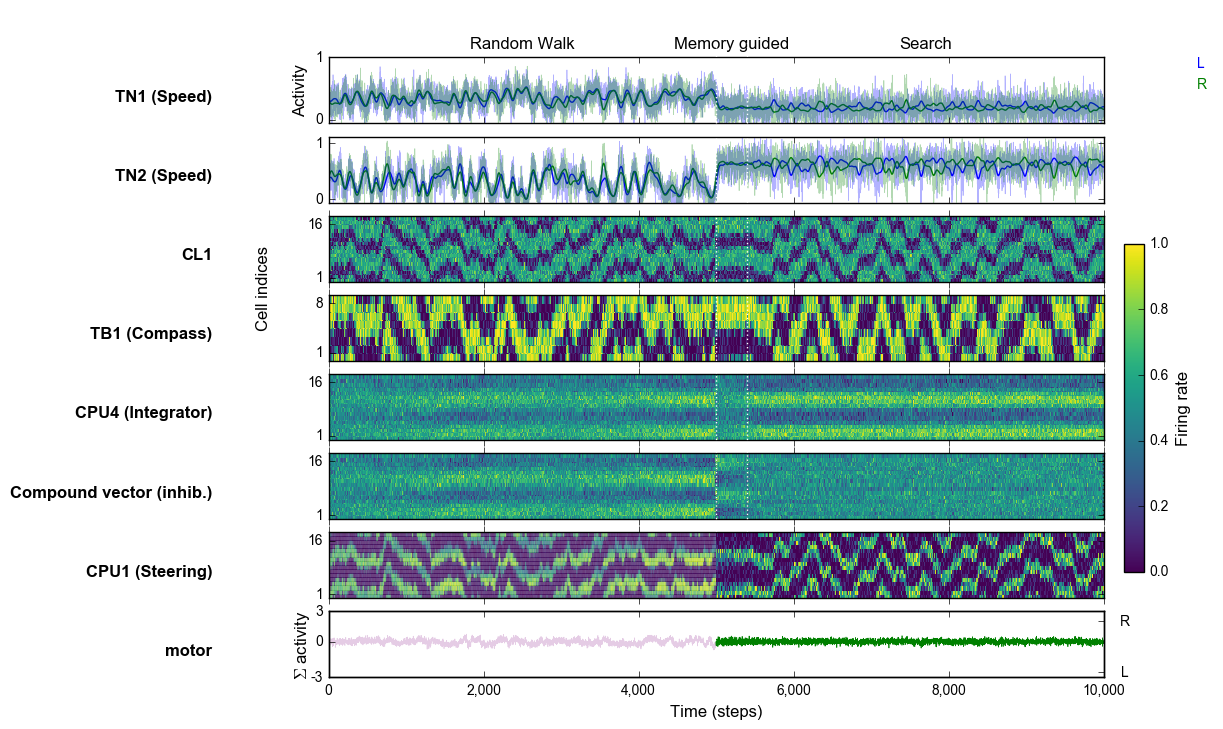

In [60]:
# Add the two logs (random and food-ward) to plot the full activity graph
log_full = log_p1+log_p2

fig, ax = plotter2.plot_traces(log_full, figsize=(10,8))

# Re-calibration experiment

In [17]:
# Example of arena + feeders to reproduce Collett et al. 1999

arena = modules.generate_arena((360, 330), walls_detection_dist=4, arena_offset=[45,150])

feederA = np.array([-120, 300])
feederB = np.array([210, 270])

gutter = modules.Wall((15, -10),(240, 260), detection=7)

In [23]:
# Perform the random walk.

h_randwalk, v_randwalk, T_randwalk, log_randwalk, success = modules.move(goal_coord=feederA,
                                                                        T_max=10000,
                                                                        goal_radius=feeder_radius,
                                                                        random_exploring=True,
                                                                        arena=arena,
                                                                        stop_when_food=True,
                                                                        logging=True,
                                                                        return_success=True
                                                                        )
if success == 1:
    print('Feeder A found!')
else:
    print('Not found :(')
success = 0

Feeder A found!


In [25]:
# Follow memory for homing, but with forced displacement along the gutter

h_forced, v_forced, T_forced, log_forced, success = modules.move(goal_coord='Nest',
                                                                T_max=2000,
                                                                memory=log_p1.memory[:,-1],
                                                                tb1=log_p1.tb1[:,-1],
                                                                goal_radius=nest_radius,
                                                                random_exploring=False,
                                                                arena=arena,
                                                                obstacle=gutter,
                                                                stop_when_food=True,
                                                                logging=True,
                                                                return_success=True,
                                                                inhib_gain=1.05,
                                                                keep_searching=False,
                                                                start_coord=feederB
                                                                )

if success == 1:
    print('Nest found!')
else:
    print('Not found :(')
success = 0

Nest found!


(-15, 315)

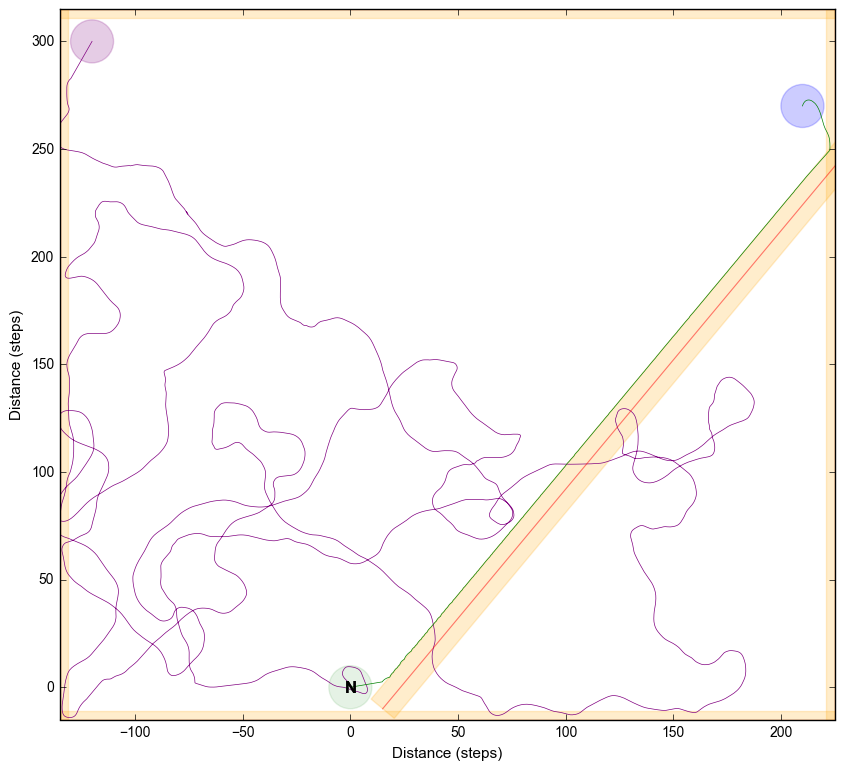

In [26]:
# Plot the two parts (purple is random walk and green is forced homing)

figsize=(10,10)

fig, ax = plotter2.plot_route(h_randwalk,
                              v_randwalk,
                              T_outbound=T_randwalk,
                              T_inbound=0,
                              plot_speed=False,
                              plot_heading=False,
                              nest_label=True,
                              legend=False,
                              figsize=figsize,
                             )

plotter2.plot_route(h_forced,
                    v_forced,
                    T_outbound=0,
                    T_inbound=T_forced,
                    ax=ax,
                    plot_speed=False,
                    plot_heading=False,
                    nest_label=True,
                    legend=False,
                    figsize=figsize,
                    start_coord=feederB
                   )

plotter2.plot_arena(arena, ax=ax)
plotter2.plot_obstacle(gutter, ax=ax)

ax.add_artist(plt.Circle(feederA, 10, color='purple', alpha=.2))
ax.add_artist(plt.Circle(feederB, 10, color='blue', alpha=.2))

ax.add_artist(plt.Circle((0,0), 10, color='g', alpha=.1))
ax.set_xlim((-135, 225))
ax.set_ylim((-15, 315))

### Influence of gain

In [32]:
# Generate a recalibrated memory for each gain value

gains = (np.arange(0, 11, 0.5).astype(float)/10)[:-1]
mems = np.zeros((len(gains), 16))

for g, val in enumerate(gains):
    mem = cx.cpu4_inhibition(log_p1.memory[:,-1], log_p2.memory[:,-1], gain=val)
    mems[g,:] = mem

In [34]:
# Perform the foodward routes for each re-calibrated memory

N = 1
T_max = 400  # Cut the routes at 400 steps to remove random searches (for clarity)

HH = np.zeros((len(gains),N,T_max-1))
VV = np.zeros((len(gains),N,T_max-1,2))

for g, gain in enumerate(gains):

    H = np.zeros((N,T_max-1))
    V = np.zeros((N,T_max-1,2))

    for i in range(0,N):
        h_p3, v_p3, T_p3, log_p3, success = modules.move(T_max=T_max,
                                                         ltm=mems[g,:],
                                                         goal_radius=10,
                                                         random_exploring=False,
                                                         arena=False,
                                                         stop_when_food=True,
                                                         logging=True,
                                                         return_success=True,
                                                         inhib_gain=1.05,
                                                         keep_searching=True
                                                        )

        H[i,:] = h_p3
        V[i, :,:] = v_p3
        
    HH[g,:,:] = H
    VV[g,:,:,:] = V

(-15, 315)

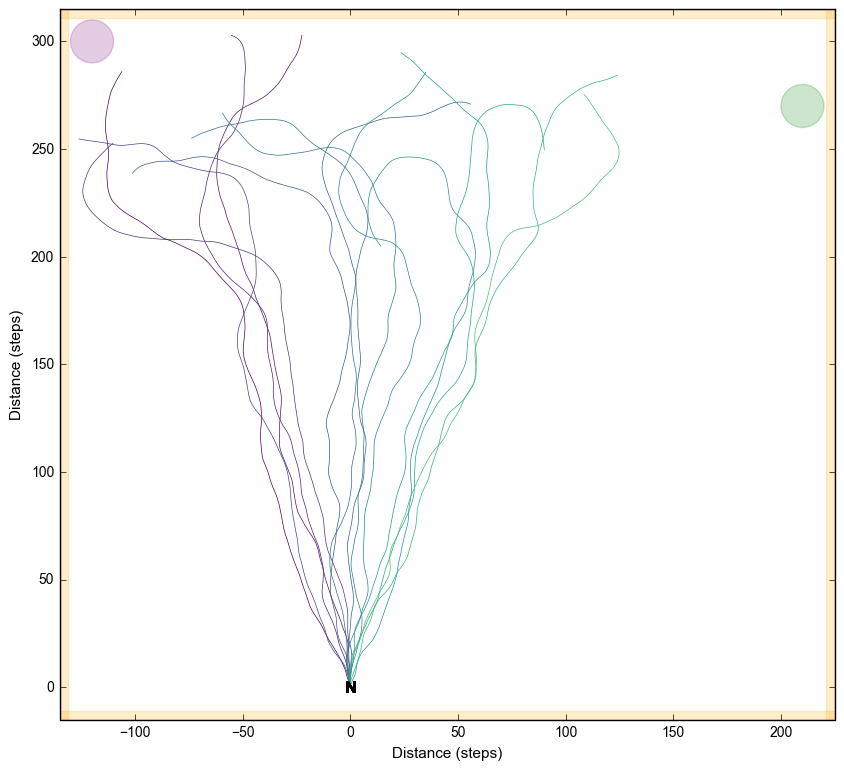

In [37]:
# Plot the traces

colors = [plotter2.cm.viridis(x) for x in np.linspace(0, 1, len(gains))]

fig, ax = plotter.plot_route(HH[0,0,:],
                             VV[0,0,:,:],
                             T_outbound=0,
                             T_inbound=T_max,
                             plot_speed=False,
                             plot_heading=False,
                             nest_label=True,
                             legend=False,
                             figsize=figsize,
                             inbound_color=colors[0]
                            )

for i in range(1, len(gains)-6):
    plotter.plot_route(HH[i,0,:],
                        VV[i,0,:,:],
                       ax=ax,
                     T_outbound=0,
                     T_inbound=T_max,
                     plot_speed=False,
                     plot_heading=False,
                     nest_label=True,
                     legend=False,
                     figsize=figsize,
                    inbound_color=colors[i]
                    )

plotter2.plot_arena(arena, ax=ax)

ax.add_artist(plt.Circle(feederA, 10, color='purple', alpha=.2))
ax.add_artist(plt.Circle(feederB, 10, color='green', alpha=.2))

#ax.add_artist(plt.Circle((0,0), 10, color='g', alpha=.1))
ax.set_xlim((-135, 225))
ax.set_ylim((-15, 315))